C:\Users\1\AppData\Local\Temp\ipykernel_9648\2137160929.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['num'], palette="viridis")


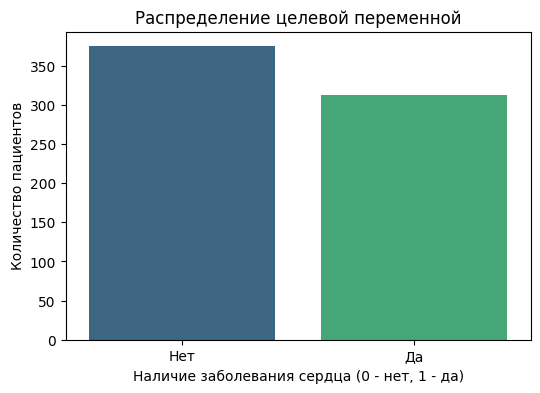

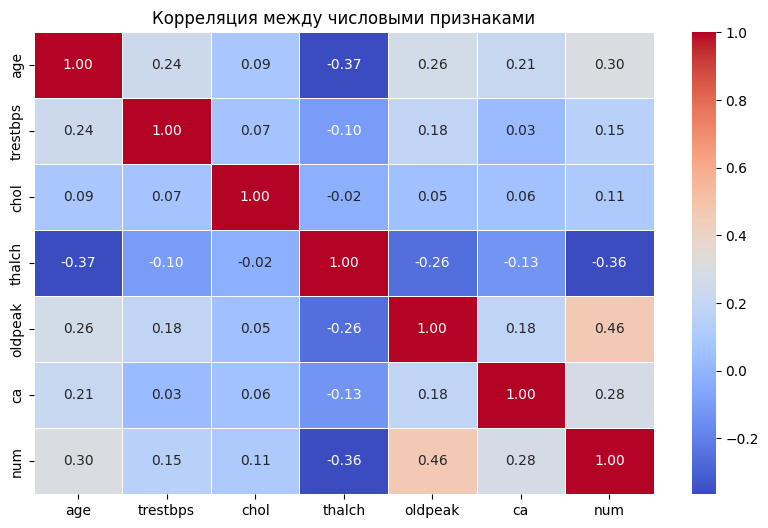

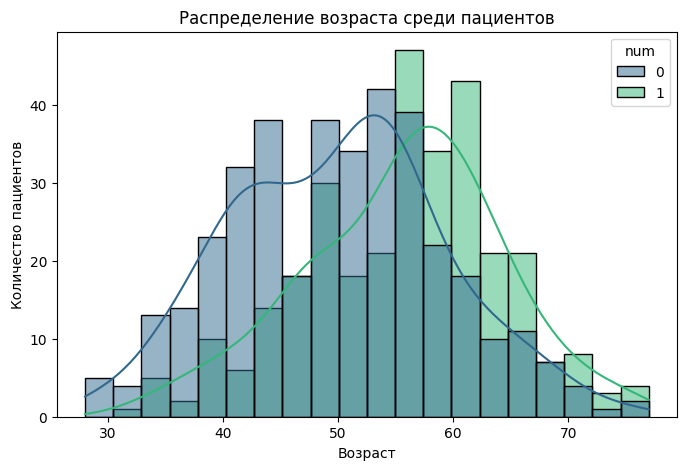


📊 Model Performance Metrics:
Accuracy: 0.7754
Precision: 0.7500
Recall: 0.7619
F1 Score: 0.7559
ROC AUC Score: 0.8652


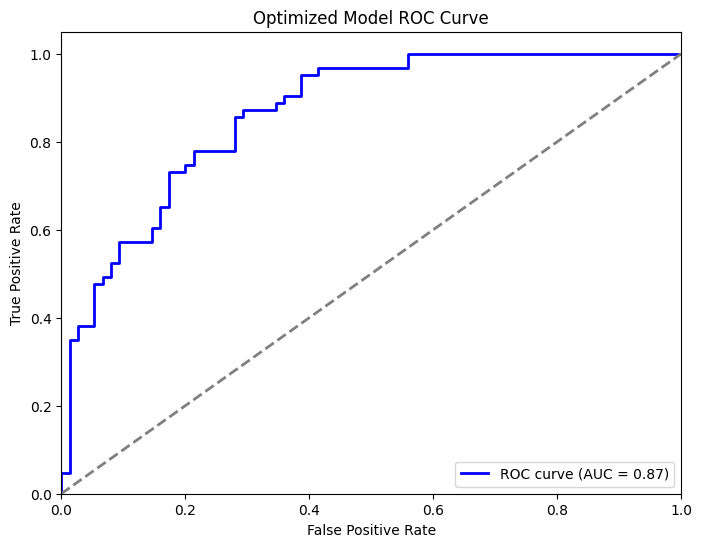

C:\Users\1\AppData\Local\Temp\ipykernel_9648\2137160929.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="viridis")


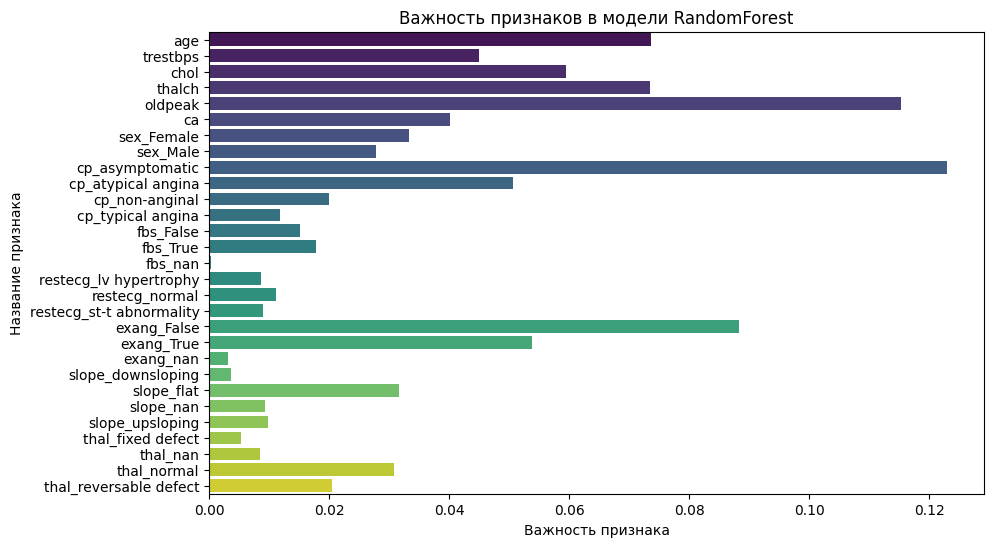

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Загрузка данных
file_path = "heart_disease_uci.csv"  # Укажите путь к файлу
df = pd.read_csv(file_path)

# Удаление дубликатов
df = df.drop_duplicates()

# Преобразуем целевую переменную в бинарный формат (0 - нет болезни, 1 - есть болезнь)
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Определение числовых и категориальных признаков
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Функция для удаления выбросов методом IQR
def remove_outliers(df, numerical_features):
    Q1 = df[numerical_features].quantile(0.25)
    Q3 = df[numerical_features].quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

# Удаляем выбросы
df = remove_outliers(df, numerical_features)

# Заполняем пропущенные значения в числовых признаках средним значением
imputer = SimpleImputer(strategy="mean")
df[numerical_features] = imputer.fit_transform(df[numerical_features])

# Преобразуем булевы категории в строки
df[categorical_features] = df[categorical_features].astype(str)

# 📊 1. Гистограмма распределения целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x=df['num'], palette="viridis")
plt.xlabel("Наличие заболевания сердца (0 - нет, 1 - да)")
plt.ylabel("Количество пациентов")
plt.title("Распределение целевой переменной")
plt.xticks(ticks=[0, 1], labels=["Нет", "Да"])
plt.show()

# 📊 2. Корреляция между числовыми признаками
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_features + ['num']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляция между числовыми признаками")
plt.show()

# 📊 3. Распределение возрастов среди больных и здоровых пациентов
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="age", hue="num", kde=True, palette="viridis", bins=20)
plt.xlabel("Возраст")
plt.ylabel("Количество пациентов")
plt.title("Распределение возраста среди пациентов")
plt.show()

# Разделение данных на обучающую и тестовую выборки
X = df.drop(columns=['id', 'origin', 'num'])
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование данных
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Оптимизация модели с помощью GridSearchCV
model = RandomForestClassifier(random_state=42)
pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель после оптимизации
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Предсказания с оптимизированной моделью
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Итоговые метрики
final_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_proba)
}

# Вывод метрик
print("\n📊 Model Performance Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Важность признаков
feature_importances = best_model.named_steps['classifier'].feature_importances_
cat_feature_names = best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_feature_names)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel("Важность признака")
plt.ylabel("Название признака")
plt.title("Важность признаков в модели RandomForest")
plt.show()


✅ Предобработка данных

* Удаление дубликатов
* Обнаружение и удаление выбросов (метод IQR)
* Обработка пропущенных значений
* Кодирование категориальных признаков

✅ Построение модели машинного обучения

* Используется RandomForestClassifier
* Разделение train/test
* Оптимизация гиперпараметров (GridSearchCV)

✅ Оценка модели по метрикам качества

* Accuracy (Точность)
* Precision (Точность положительных предсказаний)
* Recall (Чувствительность)
* F1 Score (Сбалансированная метрика)
* ROC AUC Score (Площадь под ROC-кривой)

✅ Вывод графиков для интерпретации

* ROC-кривая (Оценка качества классификации)
* Важность признаков (Какие факторы влияют на прогноз)